In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import config.config as config

In [31]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-01 00:36:58,792 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-01 00:36:58,848 INFO: Initializing external client
2025-03-01 00:36:58,849 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-01 00:36:59,834 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214648


In [32]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1214648/featurestores/1202279/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view_v2, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view_v2, version: 1
Feature view 'time_series_hourly_feature_view_v2' (version 1) retrieved successfully.


In [33]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides V2"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (8.30s) 


In [34]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [35]:
ts_data.head()

,pickup_hour,pickup_location_id,zone,rides
0,2024-02-03 06:00:00+00:00,2,"Jamaica Bay, Queens",0
1,2024-02-03 07:00:00+00:00,2,"Jamaica Bay, Queens",0
2,2024-02-03 08:00:00+00:00,2,"Jamaica Bay, Queens",0
3,2024-02-03 09:00:00+00:00,2,"Jamaica Bay, Queens",0
4,2024-02-03 10:00:00+00:00,2,"Jamaica Bay, Queens",0


In [36]:
ts_data["pickup_hour"].min()

'2024-02-03 06:00:00+00:00'

In [37]:
ts_data["pickup_hour"].max()

'2025-03-01 05:00:00+00:00'

In [38]:
ts_data_copy = ts_data.copy()

In [39]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392324 entries, 0 to 2392323
Data columns (total 4 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   pickup_hour         object
 1   pickup_location_id  int32 
 2   zone                object
 3   rides               int32 
dtypes: int32(2), object(2)
memory usage: 54.8+ MB


In [40]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [41]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392324 entries, 0 to 2392323
Data columns (total 4 columns):
 #   Column              Dtype              
---  ------              -----              
 0   pickup_hour         datetime64[ns, UTC]
 1   pickup_location_id  int32              
 2   zone                object             
 3   rides               int32              
dtypes: datetime64[ns, UTC](1), int32(2), object(1)
memory usage: 54.8+ MB


In [42]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [43]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392324 entries, 0 to 2392323
Data columns (total 4 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   zone                object        
 3   rides               int32         
dtypes: datetime64[ns](1), int32(2), object(1)
memory usage: 54.8+ MB


In [44]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [45]:
ts_data

,pickup_hour,pickup_location_id,zone,rides,year_month
0,2024-02-03 06:00:00,2,"Jamaica Bay, Queens",0,2024-02
1,2024-02-03 07:00:00,2,"Jamaica Bay, Queens",0,2024-02
2,2024-02-03 08:00:00,2,"Jamaica Bay, Queens",0,2024-02
3,2024-02-03 09:00:00,2,"Jamaica Bay, Queens",0,2024-02
4,2024-02-03 10:00:00,2,"Jamaica Bay, Queens",0,2024-02
...,...,...,...,...,...
2392319,2025-03-01 01:00:00,263,"Yorkville West, Manhattan",70,2025-03
2392320,2025-03-01 02:00:00,263,"Yorkville West, Manhattan",33,2025-03
2392321,2025-03-01 03:00:00,263,"Yorkville West, Manhattan",34,2025-03
2392322,2025-03-01 04:00:00,263,"Yorkville West, Manhattan",11,2025-03


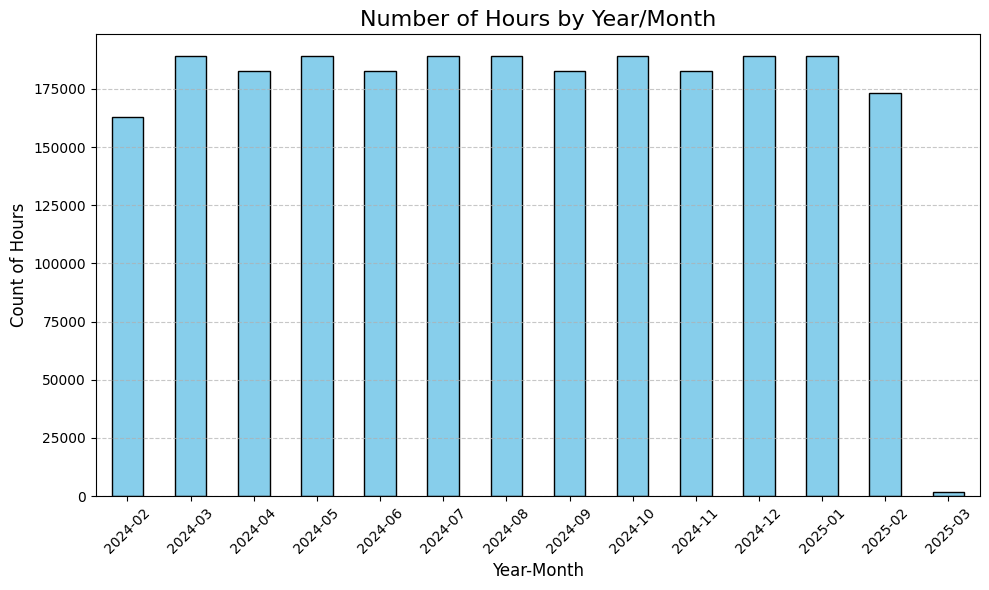

In [46]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [47]:
ts_data.head()      

,pickup_hour,pickup_location_id,zone,rides,year_month
0,2024-02-03 06:00:00,2,"Jamaica Bay, Queens",0,2024-02
1,2024-02-03 07:00:00,2,"Jamaica Bay, Queens",0,2024-02
2,2024-02-03 08:00:00,2,"Jamaica Bay, Queens",0,2024-02
3,2024-02-03 09:00:00,2,"Jamaica Bay, Queens",0,2024-02
4,2024-02-03 10:00:00,2,"Jamaica Bay, Queens",0,2024-02


In [48]:
gte = ts_data["year_month"] >= pd.Period("2024-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2025-02", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [49]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [50]:
filtered_data.shape

(2390780, 4)

In [51]:
ts_data = filtered_data

In [52]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390780 entries, 0 to 2390779
Data columns (total 4 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   zone                object        
 3   rides               int32         
dtypes: datetime64[ns](1), int32(2), object(1)
memory usage: 54.7+ MB


In [53]:
ts_data.head()["pickup_hour"].values

array(['2024-02-03T06:00:00.000000000', '2024-02-03T07:00:00.000000000',
       '2024-02-03T08:00:00.000000000', '2024-02-03T09:00:00.000000000',
       '2024-02-03T10:00:00.000000000'], dtype='datetime64[ns]')

In [54]:
from src.data_fetching_and_processing.transform_ts_data_to_features_and_target import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

Skipping location_id 27: Not enough data to create even one window.
Skipping location_id 111: Not enough data to create even one window.
Skipping location_id 199: Not enough data to create even one window.
Skipping location_id 251: Not enough data to create even one window.


In [55]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-03-02 06:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-03-03 05:00:00,2
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2024-03-04 04:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-03-05 03:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-03-06 02:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-02-24 15:00:00,263
96516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-02-25 14:00:00,263
96517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-02-26 13:00:00,263
96518,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-02-27 12:00:00,263


In [56]:
features[features["pickup_location_id"] == 2]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-03-02 06:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-03-03 05:00:00,2
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2024-03-04 04:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-03-05 03:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-03-06 02:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-02-24 15:00:00,2
376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-02-25 14:00:00,2
377,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-02-26 13:00:00,2
378,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-02-27 12:00:00,2


In [57]:
features_copy = features.copy()

In [58]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(96520, 675)

In [61]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.utils.data_utils.split_timeseries_data  import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-02-01 00:43:15.867021')

In [62]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(89154, 674)
(89154,)
(7366, 674)
(7366,)


In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89154 entries, 0 to 89153
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 458.1 MB


In [65]:
from src.utils.pipeline_utils.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [66]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86722
[LightGBM] [Info] Number of data points in the train set: 96520, number of used features: 608
[LightGBM] [Info] Start training from score 0.053232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x309cf65c0>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [67]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [68]:
predictions

array([1.41392946e-06, 1.41392946e-06, 1.41392946e-06, ...,
       1.41392946e-06, 1.41392946e-06, 1.44739617e+02])

In [69]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

0.0125


In [70]:
import joblib  

# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['/Users/vaibhavbansal/ProjectSeries/Taxi-Ride-Prediction-V2/models/lgb_model.pkl']

In [71]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [72]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour_v2",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
    # include_files=["/", "requirements.txt"]  # Include directories and files
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save('/Users/vaibhavbansal/ProjectSeries/Taxi-Ride-Prediction-V2/models/lgb_model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/206667 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2048 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/48705 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1214648/models/taxi_demand_predictor_next_hour_v2/1


Model(name: 'taxi_demand_predictor_next_hour_v2', version: 1)

In [74]:
from src.utils.inference_utils.inference_utils import load_model_from_registry

model = load_model_from_registry()

2025-03-01 00:46:38,972 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-01 00:46:38,991 INFO: Initializing external client
2025-03-01 00:46:38,992 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-01 00:46:39,921 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214648

In [75]:
from src.utils.inference_utils.inference_utils import get_model_predictions

In [76]:
preds = get_model_predictions(model, features_copy)

In [77]:
preds

,pickup_location_id,predicted_demand
0,2,0.0
1,2,0.0
2,2,0.0
3,2,0.0
4,2,0.0
...,...,...
96515,263,0.0
96516,263,0.0
96517,263,0.0
96518,263,0.0


In [78]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

0.0124
